In [16]:
import PIL
from PIL import Image
from PIL import ImageEnhance
from PIL import Image, ImageDraw, ImageFont

# read image and convert to RGB
image=Image.open("images/msi_recruitment.png")
image=image.convert('RGB')

In [17]:
ANNOTATION_HEIGHT = 75
ANNOTATION_FONT_SIZE = 40
ANNOTATION_FONT_PATH = 'fonts/FanwoodText-Regular.ttf'

In [18]:
def adj_pixel(px, band, adj):
    """Takes a pixel, essentially a tuple with three numbers 0-255 representing
    RGB values, and adjusts band by the adjustment factor."""
    
    # Handle lazy parameter calling
    band = band.lower()
    
    # Some basic validation of inputs
    assert band in ['r', 'g', 'b'], "Band is not one of 'r', 'g' or 'b'"
    assert adj <=1 and adj >=0, 'Adjustment value is out of bounds'
    assert type(px)==type((1,1,1)), 'Valid pixel tuple not passed'
    assert len(px)==3, 'Pixel passed not of length 3'
    
    # We want to elegantly select the band for adjustment using the 
    # input variable, so make a dictionary for the pixel
    px_dic = dict(zip(['r', 'g', 'b'], px))
    
    # Get current band value
    curr_val = px_dic[band]

    # Calc new val (RGB channels must only contain integers)
    new_val = int(curr_val * adj)
    
    # Update pixel dictionary
    px_dic[band] = new_val
    
    # Covert back to tuple
    px_adj = tuple(px_dic.values())
    return px_adj

In [27]:
def make_annotation(channel, intensity):
    # Create a new image that will hold the text based on original image's width and 
    # constant height
    txt = Image.new('RGB', (image.width, ANNOTATION_HEIGHT))
    
    # Get a font
    fnt = ImageFont.truetype(ANNOTATION_FONT_PATH, ANNOTATION_FONT_SIZE)
    
    # Get a drawing context
    d = ImageDraw.Draw(txt)
    
    # Construct string to draw
    annotation = 'channel {} intensity {}'.format(channel, intensity)
    
    # Draw text padded 10px from left
    d.text((10, ANNOTATION_HEIGHT*0.3), annotation, font=fnt, fill=(255,255,255))

    return txt

In [28]:
# Create a contact sheet
def create_contact_sheet(sample_image, size=(3,3)):
    """Takes a list of images and a tuple grid for contact sheet creation"""
    contact_sheet = PIL.Image.new(sample_image.mode, (sample_image.width*size[0],(sample_image.height)*size[1]))
    return contact_sheet

In [29]:
# getdata() returns a PIL object so convert to list for easy manipulation
img_data_list = list(image.getdata())

# Copy of image to paste over
image_to_adjust = image.copy()

In [30]:
# Loop will iterate over channels and intensities, using map to adjust pixels, appending
# the adjusted images to the images list
images=[]
annotations=[]
image_data_list = list(image.getdata())

for channel in image.getbands():
    for intensity in [0.1, 0.5, 0.9]:
        img_adj_list = list(map(lambda x: adj_pixel(x, channel, intensity), img_data_list))
        
        # Important to create a new images each time because: 
        # 1. For whatever reason, merely repeatedly copying over image_to_adjust 
        #    relying on the side-effect of putdata was not working, and only the final 
        #    image was in the images list 9 times...
        # 2. We need some space at the bottom to annotate the final image.        
        image_to_adjust =  PIL.Image.new(image.mode, size=(image.width,image.height+ANNOTATION_HEIGHT))
        image_to_adjust.putdata(img_adj_list)
        
        # Just some logging so we know what's happening
        print('Appending image for {} channel at intensity {}'.format(channel, intensity))
        images.append(image_to_adjust)
        
        # Log annotation creation and create
        print('Creating annotation for {} channel at intensity {}'.format(channel, intensity))
        annotations.append(make_annotation(channel, intensity))
        
        # Finally create the payload of images and annotations for arranging on a contact sheet
        payload = zip(images, annotations)

Appending image for R channel at intensity 0.1
Creating annotation for R channel at intensity 0.1
Appending image for R channel at intensity 0.5
Creating annotation for R channel at intensity 0.5
Appending image for R channel at intensity 0.9
Creating annotation for R channel at intensity 0.9
Appending image for G channel at intensity 0.1
Creating annotation for G channel at intensity 0.1
Appending image for G channel at intensity 0.5
Creating annotation for G channel at intensity 0.5
Appending image for G channel at intensity 0.9
Creating annotation for G channel at intensity 0.9
Appending image for B channel at intensity 0.1
Creating annotation for B channel at intensity 0.1
Appending image for B channel at intensity 0.5
Creating annotation for B channel at intensity 0.5
Appending image for B channel at intensity 0.9
Creating annotation for B channel at intensity 0.9


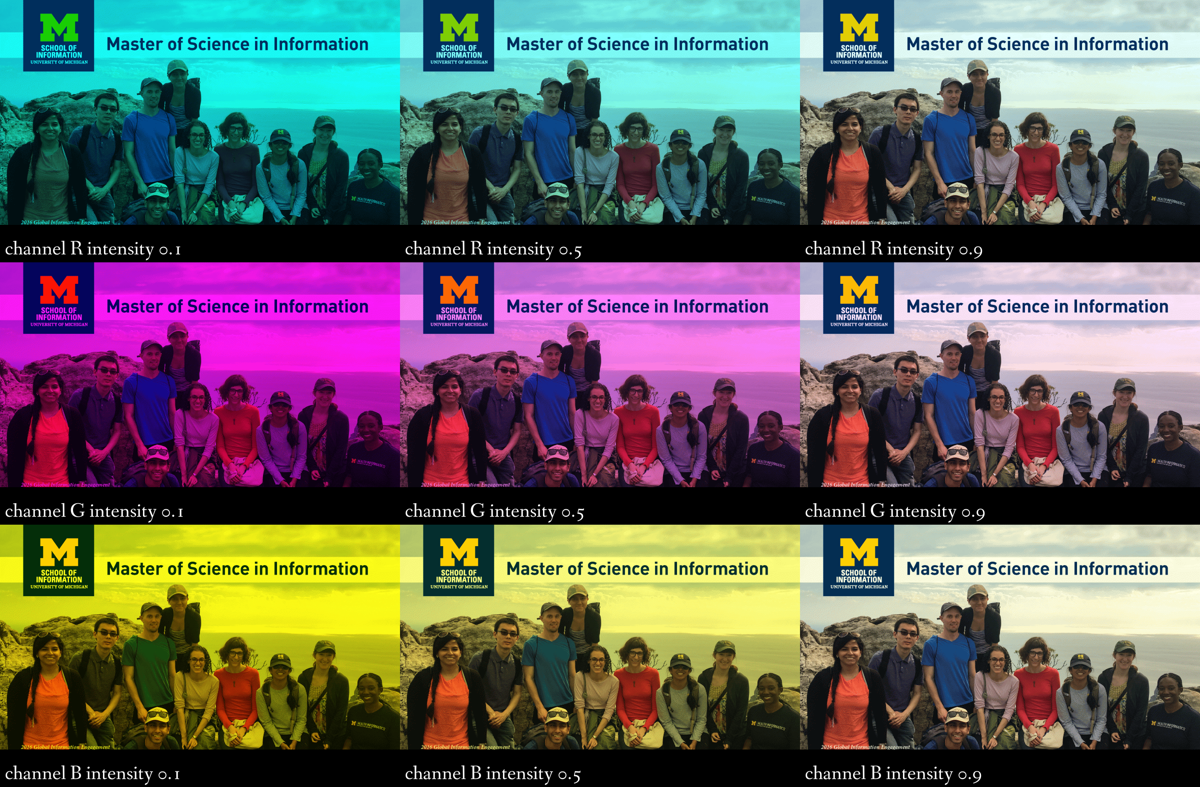

In [31]:
# Create, then paste onto the contact sheet
first_image = images[0]
contact_sheet = create_contact_sheet(first_image)
x=0
y=0
for (img, anno) in payload:
    # Let's paste the current image into the contact sheet
    contact_sheet.paste(img, (x, y))
    
    # Then paste annotation
    contact_sheet.paste(anno, (x, y+450))
    
    # Now we update our X position. If the value of x is at the edge of the contact sheet,
    # then we reset it back to 0 and move y down a row (i.e. the value of the image height).
    if x + first_image.width == contact_sheet.width:
        x = 0
        y = y + first_image.height
    else:
        x = x + first_image.width
        
# Resize and display the contact sheet
contact_sheet_display = contact_sheet.resize((int(contact_sheet.width/2),int(contact_sheet.height/2) ))
display(contact_sheet_display)